In [1]:
library(BiocManager)
library(BSgenome.Hsapiens.UCSC.hg38)
library(ArchR)
library(ggplot2)
library(TFBSTools)
library(Seurat)
library(ggplot2)
library(dplyr)
library(harmony)
#library(SeuratData)
library(Signac)
library(BSgenome.Hsapiens.UCSC.hg38)
library(JASPAR2018)
library(edgeR)

library(ArchR)
data("geneAnnoHg38")
data("genomeAnnoHg38")
geneAnno <- geneAnnoHg38
genomeAnno <- genomeAnnoHg38
addArchRThreads(12)


Bioconductor version '3.12' is out-of-date; the current release version '3.16'
  is available with R version '4.2'; see https://bioconductor.org/install

Loading required package: BSgenome

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdif

In [3]:
library(Matrix)
library(SummarizedExperiment)
library(uwot)
library(edgeR)
library(FNN)
library(matrixStats)
library(Rcpp)
set.seed(1)

In [4]:
sparseRowVariances <- function (m){
    rM <- Matrix::rowMeans(m)
    rV <- computeSparseRowVariances(m@i + 1, m@x, rM, ncol(m))
    return(rV)
}

#Helper function for summing sparse matrix groups
groupSums <- function (mat, groups = NULL, na.rm = TRUE, sparse = FALSE){
    stopifnot(!is.null(groups))
    stopifnot(length(groups) == ncol(mat))
    gm <- lapply(unique(groups), function(x) {
        if (sparse) {
            Matrix::rowSums(mat[, which(groups == x), drop = F], na.rm = na.rm)
        }
        else {
            rowSums(mat[, which(groups == x), drop = F], na.rm = na.rm)
        }
    }) %>% Reduce("cbind", .)
    colnames(gm) <- unique(groups)
    return(gm)
}

sparseMatTTest <- function(mat1, mat2, m0 = 0){
	#Get Population Values
	n1 <- ncol(mat1)
	n2 <- ncol(mat2)
	n <- n1 + n2
	#Sparse Row Means
	m1 <- Matrix::rowMeans(mat1, na.rm=TRUE)
	m2 <- Matrix::rowMeans(mat2, na.rm=TRUE)
	#Sparse Row Variances
	v1 <- ArchR:::computeSparseRowVariances(mat1@i + 1, mat1@x, m1, n1)
	v2 <- ArchR:::computeSparseRowVariances(mat2@i + 1, mat2@x, m2, n2)
	#Calculate T Statistic
	se <- sqrt( (1/n1 + 1/n2) * ((n1-1)*v1 + (n2-1)*v2)/(n1+n2-2) )
    tstat <- (m1-m2-m0)/se
	#tstat <- sqrt((n1 * n2) / n) / sqrt((n1-1)/(n-2)*v1 + (n2-1)/(n-2)*v2)
	pvalue <- 2*pt(-abs(tstat), n - 2)
	fdr <- p.adjust(pvalue, method = "fdr")
	out <- data.frame(fdr = fdr, pval = pvalue, tstat = tstat, mean1 = m1, mean2 = m2, var1 = v1, var2 = v2, n1 = n1, n2 = n2)
	return(out)
}

In [5]:
fn <- unclass(lsf.str(envir = asNamespace("ArchR"), all = TRUE))
 for(i in seq_along(fn)){
  tryCatch({
   eval(parse(text=paste0(fn[i], '<-ArchR:::', fn[i])))
  }, error = function(x){
  })
 }

In [6]:
# Code below adapted from ArchR function
projectLSI <- function(mat_se = NULL, LSI = NULL){  
    require(Matrix)
    set.seed(LSI$seed)

    subset_rows <- paste(rowData(mat_se)$seqnames, rowData(mat_se)$start) %in% paste(LSI$LSIFeatures$seqnames, LSI$LSIFeatures$start)
    mat <- assay(mat_se)
    mat <- mat[subset_rows,]

    #Get Same Features--whats stored here in lsi isnt exactly whats needed, so I added the lines above this to subset
    mat <- mat[LSI$idx,]

    #Binarize Matrix
    if(LSI$binarize){
        mat@x[mat@x > 0] <- 1       
    }
    
    #TF
    colSm <- Matrix::colSums(mat)
    if(any(colSm == 0)){
      exclude <- which(colSm==0)
      mat <- mat[,-exclude]
      colSm <- colSm[-exclude]
    }
    mat@x <- mat@x / rep.int(colSm, Matrix::diff(mat@p))

    #Adapted from Stuart et al.

    #IDF
    idf   <- as(LSI$nCol / LSI$rowSm, "sparseVector")

    #TF-IDF
    mat <- as(Matrix::Diagonal(x=as.vector(idf)), "sparseMatrix") %*% mat

    #Log transform TF-IDF
    mat@x <- log(mat@x * LSI$scaleTo + 1) 

    gc()

    #Clean Up Matrix
    idxNA <- Matrix::which(is.na(mat),arr.ind=TRUE)
    if(length(idxNA) > 0){
        mat[idxNA] <- 0
    }

    #Calc V
    V <- Matrix::t(mat) %*% LSI$svd$u %*% Matrix::diag(1/LSI$svd$d)

    #LSI Diagonal
    svdDiag <- matrix(0, nrow=LSI$nDimensions, ncol=LSI$nDimensions)
    diag(svdDiag) <- LSI$svd$d
    matSVD <- Matrix::t(svdDiag %*% Matrix::t(V))
    matSVD <- as.matrix(matSVD)
    rownames(matSVD) <- colnames(mat)
    colnames(matSVD) <- paste0("LSI",seq_len(ncol(matSVD)))
    matSVD
}


In [42]:
# Load normal project and project for all samples
proj_featal_invivo <- loadArchRProject(path = "Path to archr file with healthy fetal and adult tissue")


proj_all_invitro_peaks <- loadArchRProject(path = "Path to archr file with GBM39 or GBM45 cancer project")



Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .____

In [9]:
# Load saved lsi
lsi <- getReducedDims(proj_featal_invivo, reducedDims = "IterativeLSI", returnMatrix = FALSE)

# Load Saved UMAP Manifold
umap <- getEmbedding(proj_featal_invivo, embedding = "UMAP", returnDF = FALSE)
umapManifold <- uwot::load_uwot(umap$params$uwotModel[1])



ArchR logging to : ArchRLogs/ArchR-getMatrixFromProject-7af03ff948e1-Date-2023-04-05_Time-18-11-49.log
If there is an issue, please report to github with logFile!

2023-04-05 18:12:06 : Organizing colData, 0.288 mins elapsed.

2023-04-05 18:12:06 : Organizing rowData, 0.288 mins elapsed.

2023-04-05 18:12:06 : Organizing rowRanges, 0.288 mins elapsed.

2023-04-05 18:12:06 : Organizing Assays (1 of 1), 0.288 mins elapsed.

2023-04-05 18:12:06 : Constructing SummarizedExperiment, 0.288 mins elapsed.

2023-04-05 18:12:08 : Finished Matrix Creation, 0.32 mins elapsed.

18:12:18 Read 217 rows
 and found 30 numeric columns

18:12:18 Processing block 1 of 1

18:12:18 Writing NN index file to temp file /scratch/5189594.1.himem/RtmpconR0x/file7af03f62be9b

18:12:18 Searching Annoy index using 48 threads, search_k = 4000

18:12:18 Commencing smooth kNN distance calibration using 48 threads

18:12:18 Initializing by weighted average of neighbor coordinates using 48 threads

18:12:18 Commencing op

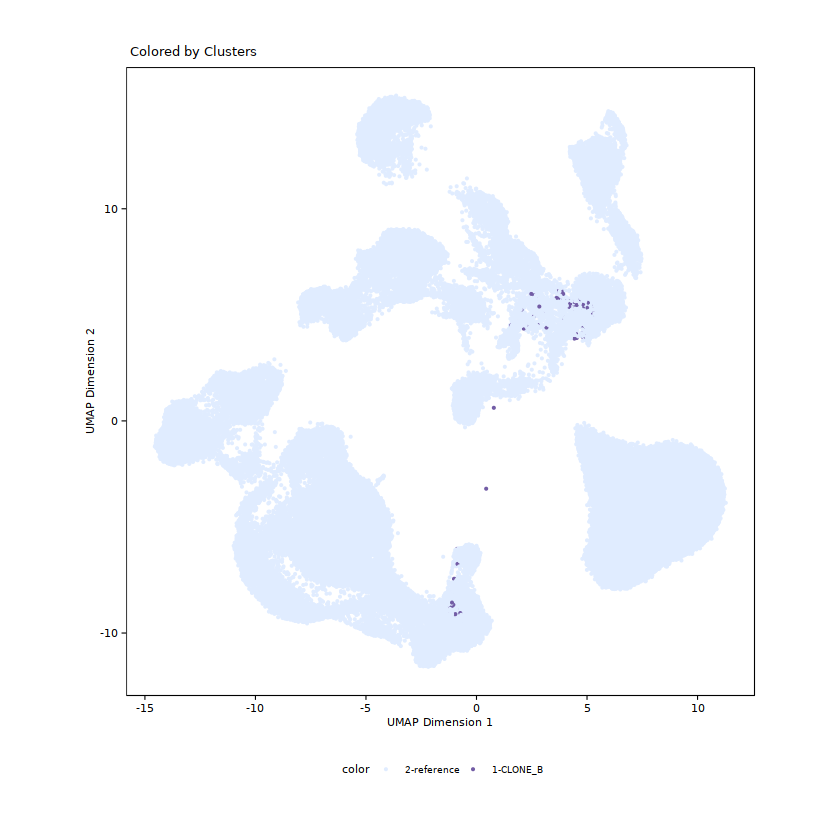

In [64]:
#subsetting subclones and projecting it to fetal or adult cells
temp<-subsetCells(proj_all_invitro_peaks,cell=rownames(proj_all_invitro_peaks[ (proj_all_invitro_peaks$subcloneclusters %in% c('B')) ,]))

mat_se <- getMatrixFromProject(temp,
  useMatrix = "TileMatrix",
  useSeqnames = NULL,
  verbose = TRUE,
  binarize = TRUE
)





lsiProjection <- projectLSI(mat_se, lsi)
#UMAP Projection
set.seed(1)
umapProjection <- uwot::umap_transform(as.matrix(lsiProjection)[,1:30], umapManifold, verbose = TRUE)
#Plot Projection
refDF <- data.frame(row.names = proj_featal_invivo$CellNames , X1 = umapManifold$embedding[,1], X2 = umapManifold$embedding[,2], Type = "reference")
proDF <- data.frame(row.names = temp$cellNames, X1 = umapProjection[,1], X2 = umapProjection[,2], Type = "CLONE_B")
#proDF <- data.frame(row.names = proj_all_invitro_peaks$CellNames, X1 = umapProjection[,1], X2 = umapProjection[,2], Type = "Tcells")
projectionDF <- rbind(refDF, proDF)
#
plotParams <- list()
plotParams$x <- projectionDF[, 'X1']
plotParams$y <- projectionDF[, 'X2']
plotParams$title <- " Colored by Clusters"
plotParams$baseSize <- 6
plotParams$rastr <- FALSE
plotParams$xlabel <- "UMAP Dimension 1"
plotParams$ylabel <- "UMAP Dimension 2"
plotParams$color <- as.character(projectionDF$Type)
plotParams$size <- 0.1
plotParams$randomize <- TRUE
plotParams$pal <- c("reference"="#E0ECFF","CLONE_B"="#725ca5")
plotParams$labelMeans <- FALSE
gg<-do.call(ggPoint,plotParams)
gg
#




In [50]:
input_knn <- 25

#LSI-SVD
svdReference <- as.data.frame(lsi$matSVD) #loaded lsi
svdDisease <- as.data.frame(as.matrix(lsiProjection)) # defined from projectLSI

#KNN Nearest Neighbor using FNN #find 25 nn cells
library(FNN)
set.seed(1)
knnDisease <- get.knnx(
    data = svdReference,
    query = svdDisease,
    k = input_knn)


In [51]:
cellcoldata<-getCellColData(proj_featal_invivo)
reqnames<-rownames(lsi$matSVD[as.vector(knnDisease$nn.index),])

[1] "Adult" "Fetal"

In [53]:
reqnames<-rownames(lsi$matSVD[as.vector(knnDisease$nn.index),])
temp_df<-data.frame(cellcoldata[reqnames,'Sample1'])
names(temp_df)<-'Tissue type'
a<-data.frame(table(temp_df)/dim(temp_df)[1])
a$Rank<-rank(a$Freq)


,temp_df,Freq,Rank
,<fct>,<dbl>,<dbl>
1,Adult,0.6254378,2
2,Fetal,0.3745622,1


,temp_df,Freq,Rank
,<fct>,<dbl>,<dbl>
1,Adult,0.6254378,2
2,Fetal,0.3745622,1


In [48]:
clonea_numbers<-a

In [54]:
cloneb_numbers<-a

In [55]:
clonea_numbers$type='clone A'
cloneb_numbers$type='clone B'

In [56]:
newdf<-rbind(clonea_numbers,cloneb_numbers)
head(newdf)
dim(newdf)

,temp_df,Freq,Rank,type
,<fct>,<dbl>,<dbl>,<chr>
1,Adult,0.1101318,1,clone A
2,Fetal,0.8898682,2,clone A
3,Adult,0.6254378,2,clone B
4,Fetal,0.3745622,1,clone B


[1] 4 4

In [57]:
pdf(file = "GBM39_NearestNeighboursplot.pdf", width = 8, height = 6) 
p1 <- ggplot(newdf) +
    geom_col(aes(x = type, y = Freq, fill = temp_df ) ) +scale_fill_manual(values = c("Adult"="#FFAC53","Fetal"="#79FFFF")) + theme_classic()

p1

dev.off()

png 
  2

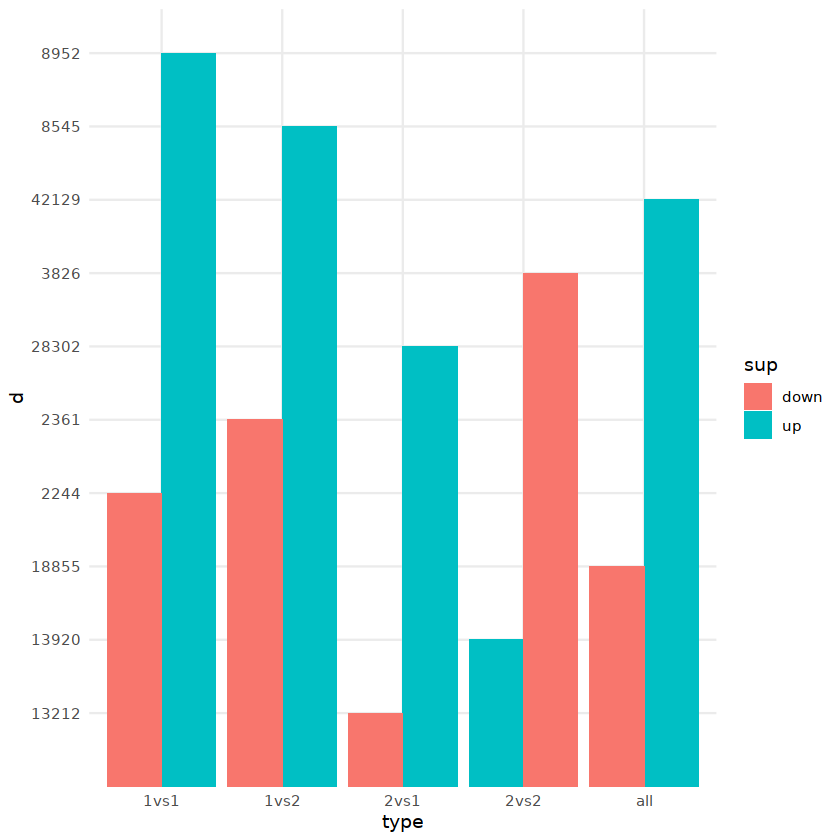

In [46]:
# Use position=position_dodge()
ggplot(data=df, aes(x=type, y=d, fill=sup)) +
geom_bar(stat="identity", position=position_dodge()) + 
  theme_minimal()

In [ ]:
1 vs 1 
8952
2244

1vs 2 
8545
2361

2 vs 1

28302
13212

2 vs 2 

13920
3826


In [16]:
peakset<-data.frame(getPeakSet(all_combined))
head(peakset)

,seqnames,start,end,width,strand,score,replicateScoreQuantile,groupScoreQuantile,Reproducibility,GroupReplicate,distToGeneStart,nearestGene,peakType,distToTSS,nearestTSS,GC,idx,N
,<fct>,<int>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>,<chr>,<int>,<chr>,<dbl>,<int>,<dbl>
1,chr1,792780,793280,501,*,2.23157,0.316,0.085,2,scATAC_BRCA_C9C8D426_A3FD_4455_89A9_768BC01D66A9_X009_S02_B1_T1._.Rep2,24340,FAM87B,Distal,7229,uc057aum.1,0.4431,1,0
2,chr1,817103,817603,501,*,4.61015,0.770,0.471,2,scATAC_BRCA_CC102C17_C1CA_427A_8C7D_D3E79748A0CD_X012_S07_B1_T1._.Rep2,17,FAM87B,Promoter,17,uc057aum.1,0.4790,2,0
3,chr1,817792,818292,501,*,13.71580,0.565,0.295,2,scATAC_BRCA_CB96A542_7AC1_4FEC_A5D2_458D8EEDC6C4_X013_S06_B1_T1._.Rep1,670,FAM87B,Exonic,670,uc057aum.1,0.5349,3,0
4,chr1,818807,819307,501,*,3.60163,0.155,0.012,2,scATAC_RM002_BRST_CC_002_X013_S05_B1_T1._.Rep1,1685,FAM87B,Exonic,1685,uc057aum.1,0.4890,4,0
5,chr1,819855,820355,501,*,3.27537,0.557,0.251,2,scATAC_BRCA_CB96A542_7AC1_4FEC_A5D2_458D8EEDC6C4_X013_S06_B1_T1._.Rep2,2733,FAM87B,Distal,2733,uc057aum.1,0.5409,5,0
6,chr1,820503,821003,501,*,2.08553,0.272,0.056,2,scATAC_BRCA_CB96A542_7AC1_4FEC_A5D2_458D8EEDC6C4_X013_S06_B1_T1._.Rep2,3381,FAM87B,Distal,3381,uc057aum.1,0.5589,6,0


In [17]:
df<-cbind(cbind(cbind(as.character(peakset$seqnames),peakset$start),peakset$end),plotDiff)
dim(df[df$type!='not-differential',])
dim(df)
#head(df)

[1] 122586      7

[1] 506237      7

In [18]:
sampleName

[1] "scATAC_BRCA_A91AADEA_8299_46D9_A250_76896D690AFD_X006_S02_B1_T1"

In [19]:
write.table(df[df$type!='not-differential',],
'/illumina/scratch/deep_learning/lsundaram/singlecelldatasets/TCGA/Fig4_differentials/scATAC_BRCA_A91AADEA_8299_46D9_A250_76896D690AFD_X006_S02_B1_T1_NN_differential.csv',
               quote=FALSE,row.names=FALSE,col.names=FALSE,sep='\t')


In [20]:
cnv_data<-read.csv('/illumina/scratch/deep_learning/lsundaram/singlecelldatasets/TCGA/Synapse/cleaned_AWS/A91AADEA_8299_46D9_A250_76896D690AFD.csv')
write.table(cnv_data[c('Chromosome','Start','End','Copy_Number')],
            '/illumina/scratch/deep_learning/lsundaram/singlecelldatasets/TCGA/Fig4_differentials/scATAC_BRCA_A91AADEA_8299_46D9_A250_76896D690AFD_X006_S02_B1_T1_NN_cnv.csv',
           quote=FALSE,row.names=FALSE,col.names=FALSE,sep='\t')
head(cnv_data)

,GDC_Aliquot,Chromosome,Start,End,Copy_Number,Major_Copy_Number,Minor_Copy_Number
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>
1,7cd9ac40-f6b5-4c68-9d9a-d57845b812db,chr1,13116,89946,6,6,0
2,7cd9ac40-f6b5-4c68-9d9a-d57845b812db,chr1,91515,586198,5,5,0
3,7cd9ac40-f6b5-4c68-9d9a-d57845b812db,chr1,591356,611267,4,4,0
4,7cd9ac40-f6b5-4c68-9d9a-d57845b812db,chr1,629218,632427,1,1,0
5,7cd9ac40-f6b5-4c68-9d9a-d57845b812db,chr1,633714,635258,3,3,0
6,7cd9ac40-f6b5-4c68-9d9a-d57845b812db,chr1,638771,775930,6,6,0


In [ ]:
bedtools intersect -a scATAC_BRCA_A91AADEA_8299_46D9_A250_76896D690AFD_X006_S02_B1_T1_NN_differential.csv -b scATAC_BRCA_A91AADEA_8299_46D9_A250_76896D690AFD_X006_S02_B1_T1_NN_cnv.csv -wo > scATAC_BRCA_A91AADEA_8299_46D9_A250_76896D690AFD_X006_S02_B1_T1_NN_differential_csv_merged.csv


bedtools intersect -a scATAC_BRCA_08499A64_3FD8_4E62_AF08_3C66AF93CAE7_X009_S01_B1_T1_NN_differential.csv -b scATAC_BRCA_08499A64_3FD8_4E62_AF08_3C66AF93CAE7_X009_S01_B1_T1_NN_cnv.csv -wo > scATAC_BRCA_08499A64_3FD8_4E62_AF08_3C66AF93CAE7_X009_S01_B1_T1_NN_differential_csv_merged.csv

bedtools intersect -a scATAC_BRCA_14AD76EE_12F9_40B3_8DCD_4A256E02CF8D_X003_S02_B1_T1_NN_differential.csv -b scATAC_BRCA_14AD76EE_12F9_40B3_8DCD_4A256E02CF8D_X003_S02_B1_T1_NN_cnv.csv -wo > scATAC_BRCA_14AD76EE_12F9_40B3_8DCD_4A256E02CF8D_X003_S02_B1_T1_NN_differential_csv_merged.csv

bedtools intersect -a scATAC_BRCA_1D939DC3_EF0C_40BF_BC60_8C5D46345265_X004_S02_B1_T1_NN_differential.csv -b scATAC_BRCA_1D939DC3_EF0C_40BF_BC60_8C5D46345265_X004_S02_B1_T1_NN_cnv.csv -wo > scATAC_BRCA_1D939DC3_EF0C_40BF_BC60_8C5D46345265_X004_S02_B1_T1_NN_differential_csv_merged.csv

bedtools intersect -a scATAC_BRCA_2A65DC63_F8CC_4EF4_AB23_3F5FD880FB5E_X010_S02_B1_T1_NN_differential.csv -b scATAC_BRCA_2A65DC63_F8CC_4EF4_AB23_3F5FD880FB5E_X010_S02_B1_T1_NN_cnv.csv -wo > scATAC_BRCA_2A65DC63_F8CC_4EF4_AB23_3F5FD880FB5E_X010_S02_B1_T1_NN_differential_csv_merged.csv

bedtools intersect -a scATAC_BRCA_5C54B79C_DA02_4B22_9FC2_3D61BFFC5559_X011_S02_B1_T1_NN_differential.csv -b scATAC_BRCA_5C54B79C_DA02_4B22_9FC2_3D61BFFC5559_X011_S02_B1_T1_NN_cnv.csv -wo > scATAC_BRCA_5C54B79C_DA02_4B22_9FC2_3D61BFFC5559_X011_S02_B1_T1_NN_differential_csv_merged.csv

bedtools intersect -a scATAC_BRCA_7C6A3AE4_E2EA_42B3_B3F1_81C19E6F2170_X005_S02_B1_T1_NN_differential.csv -b scATAC_BRCA_7C6A3AE4_E2EA_42B3_B3F1_81C19E6F2170_X005_S02_B1_T1_NN_cnv.csv -wo > scATAC_BRCA_7C6A3AE4_E2EA_42B3_B3F1_81C19E6F2170_X005_S02_B1_T1_NN_differential_csv_merged.csv





In [ ]:
name_col<-'monocytes'
tt<-data.frame(plotDiff$log2FC)
names(tt)<-name_col
#
tt1<-data.frame(plotDiff$FDR)
names(tt1)<-name_col
#
tt2<-data.frame(plotDiff$log2Mean)
names(tt2)<-name_col

In [ ]:
enrich_se <- SummarizedExperiment(assays =  SimpleList(Log2FC = tt, FDR=tt1, log2Mean=tt2 ) )
rowData(enrich_se)<-data.frame(getPeakSet(all_combined))[c('seqnames','idx','start','end')]
metadata(enrich_se)$Params$useMatrix<-"PeakMatrix"
motifsUp <- peakAnnoEnrichment(
    seMarker = enrich_se,
    ArchRProj = all_combined,
    peakAnnotation = "Motif",
    cutOff = "Log2FC >= 0.5 & FDR <= 0.1" 
 )


motifsDo <- peakAnnoEnrichment(
    seMarker = enrich_se,
    ArchRProj = all_combined,
    peakAnnotation = "Motif",
    cutOff = "FDR <= 0.1 & Log2FC <= -0.5" 
 )



In [ ]:
#
df_up <- data.frame(TF = rownames(motifsUp), mlog10Padj = assay(motifsUp)[,1])
df_up <- df_up[order(df_up$mlog10Padj, decreasing = TRUE),]
df_up$rank <- seq_len(nrow(df_up))
#
df_down <- data.frame(TF = rownames(motifsDo), mlog10Padj = assay(motifsDo)[,1])
df_down <- df_down[order(df_down$mlog10Padj, decreasing = TRUE),]
df_down$rank <- seq_len(nrow(df_down))

In [ ]:
#tcELLS
wt_1_plotdiff<-plotDiff
wt_1_up<-df_up
wt_1_down<-df_down

In [ ]:
head(wt_1_up)

In [ ]:
#bcells
mt_1_plotdiff<-plotDiff
mt_1_up<-df_up
mt_1_down<-df_down

In [ ]:
#monocytes
wt_2_plotdiff<-plotDiff
wt_2_up<-df_up
wt_2_down<-df_down

In [ ]:
#CC102C17
mt_2_plotdiff<-plotDiff
mt_2_up<-df_up
mt_2_down<-df_down

In [ ]:
wt_3_plotdiff<-plotDiff
wt_3_up<-df_up
wt_3_down<-df_down

In [ ]:
mt_3_plotdiff<-plotDiff
mt_3_up<-df_up
mt_3_down<-df_down

In [ ]:
wt_4_plotdiff<-plotDiff
wt_4_up<-df_up
wt_4_down<-df_down

In [ ]:
mt_4_plotdiff<-plotDiff
mt_4_up<-df_up
mt_4_down<-df_down

In [ ]:
wt_5_plotdiff<-plotDiff
wt_5_up<-df_up
wt_5_down<-df_down

In [ ]:
a<-wt_1_up
b<-wt_2_up
c<-mt_1_up

names(a)<-c('TF','basal_1_fdr_up','basal_1_rank_up')
names(b)<-c('TF','basal_2_fdr_up','basal_2_rank_up')
names(c)<-c('TF','basal_3_fdr_up','basal_3_rank_up')


j<-wt_1_down
k<-wt_2_down
l<-mt_1_down

names(j)<-c('TF','basal_1_fdr_down','basal_1_rank_down')
names(k)<-c('TF','basal_2_fdr_down','basal_2_rank_down')
names(l)<-c('TF','basal_3_fdr_down','basal_3_rank_down')






In [ ]:
a<-wt_1_up
b<-wt_2_up
c<-wt_3_up
d<-wt_4_up
#e<-wt_5_up
#f<-mt_1_up
#g<-mt_2_up
#h<-mt_3_up
#i<-mt_4_up
names(a)<-c('TF','basal_1_fdr_up','basal_1_rank_up')
names(b)<-c('TF','basal_2_fdr_up','basal_2_rank_up')
names(c)<-c('TF','basal_3_fdr_up','basal_3_rank_up')
#names(d)<-c('TF','basal_4_fdr_up','basal_4_rank_up')
names(e)<-c('TF','basal_5_fdr_up','basal_5_rank_up')
names(f)<-c('TF','basal_6_fdr_up','basal_6_rank_up')
names(g)<-c('TF','basal_7_fdr_up','basal_7_rank_up')
names(h)<-c('TF','basal_8_fdr_up','basal_8_rank_up')
names(i)<-c('TF','basal_9_fdr_up','basal_9_rank_up')

j<-wt_1_down
k<-wt_2_down
l<-wt_3_down
m<-wt_4_down
n<-wt_5_down
o<-mt_1_down
p<-mt_2_down
q<-mt_3_down
r<-mt_4_down

names(j)<-c('TF','basal_1_fdr_down','basal_1_rank_down')
names(k)<-c('TF','basal_2_fdr_down','basal_2_rank_down')
names(l)<-c('TF','basal_3_fdr_down','basal_3_rank_down')
names(m)<-c('TF','basal_4_fdr_down','basal_4_rank_down')
names(n)<-c('TF','basal_5_fdr_down','basal_5_rank_down')
names(o)<-c('TF','basal_6_fdr_down','basal_6_rank_down')
names(p)<-c('TF','basal_7_fdr_down','basal_7_rank_down')
names(q)<-c('TF','basal_8_fdr_down','basal_8_rank_down')
names(r)<-c('TF','basal_9_fdr_down','basal_9_rank_down')





In [ ]:
dim(temp)

In [ ]:
temp<-merge(a,b,on='TF')
temp<-merge(temp,c,on='TF')
temp<-merge(temp,j,on='TF')
temp<-merge(temp,k,on='TF')
temp<-merge(temp,l,on='TF')

In [ ]:
temp<-merge(a,b,on='TF')
temp<-merge(temp,c,on='TF')
temp<-merge(temp,d,on='TF')
temp<-merge(temp,e,on='TF')
temp<-merge(temp,f,on='TF')
temp<-merge(temp,g,on='TF')
temp<-merge(temp,h,on='TF')
temp<-merge(temp,i,on='TF')
temp<-merge(temp,j,on='TF')
temp<-merge(temp,k,on='TF')
temp<-merge(temp,l,on='TF')
temp<-merge(temp,m,on='TF')
temp<-merge(temp,n,on='TF')
temp<-merge(temp,o,on='TF')
temp<-merge(temp,p,on='TF')
temp<-merge(temp,q,on='TF')
temp<-merge(temp,r,on='TF')



In [ ]:
head(temp)

In [ ]:
#write.csv(temp,'/illumina/scratch/deep_learning/lsundaram/single_cell_datasets/cardiomyogenesis/all_tf_nearestneighbours_enrichments.csv',
#         row.names=FALSE,quote=FALSE)

In [ ]:
#filtering based on ranking in all pairs top 25 ranks
temp1<-temp[ ((temp$basal_1_rank_up<20) | (temp$basal_2_rank_up<20) | (temp$basal_3_rank_up<20) | 
             (temp$basal_1_rank_down<20) | (temp$basal_2_rank_down<20) | (temp$basal_3_rank_down<20)) ,]


In [ ]:
#filtering based on ranking in all pairs top 25 ranks
temp1<-temp[ ((temp$basal_1_rank_up<15) | (temp$basal_2_rank_up<15) | (temp$basal_3_rank_up<15) | (temp$basal_4_rank_up<15) | (temp$basal_5_rank_up<15)| (temp$basal_6_rank_up<15) | (temp$basal_7_rank_up<15)| (temp$basal_8_rank_up<15)| (temp$basal_9_rank_up<15) | 
              (temp$basal_1_rank_down<15) | (temp$basal_2_rank_down<15) | (temp$basal_3_rank_down<15) | (temp$basal_4_rank_down<15) | (temp$basal_5_rank_down<15)| (temp$basal_6_rank_down<15) | (temp$basal_7_rank_down<15)| (temp$basal_8_rank_down<15)| (temp$basal_9_rank_down<15) 
              ) ,]


In [ ]:
head(temp)
dim(temp1)

In [ ]:
#choosing an fdr threshold instead 
#5.2 is 10 ^ -2
#not doing this for now 
"""
temp1<-temp[ ((temp$vcm_fdr_up>5.2) | (temp$pvcm_fdr_up>5.2) | (temp$ec_fdr_up>5.2) | (temp$smc_fdr_up>5.2) | 
             (temp$epc_fdr_up>5.2) | (temp$cf_fdr_up>5.2) | (temp$vcm_fdr_down>5.2) | (temp$pvcm_fdr_down>5.2) | 
              (temp$ec_fdr_down>5.2) | (temp$smc_fdr_down>5.2) | 
             (temp$epc_fdr_down>5.2) | (temp$cf_fdr_down>5.2)) ,]

dim(temp1)
"""

In [ ]:
head(temp1[temp1$TF %like% 'TCF',])

#temp1$basal_1_fdr_down<--temp1$basal_1_fdr_down
#temp1$basal_2_fdr_down<--temp1$basal_2_fdr_down
#temp1$basal_3_fdr_down<--temp1$basal_3_fdr_down
#temp1$basal_4_fdr_down<--temp1$basal_4_fdr_down


In [ ]:
#htmap<-temp1[c('vcm_fdr_up','pvcm_fdr_up','ec_fdr_up','smc_fdr_up','cf_fdr_up','epc_fdr_up',
#              'vcm_fdr_down','pvcm_fdr_down','ec_fdr_down','smc_fdr_down','cf_fdr_down','epc_fdr_down')]
#rownames(htmap)<-temp1$TF
#htmap<-htmap[complete.cases(htmap),]
#tail(htmap)

In [ ]:
temp1$sum<-temp1$basal_1_fdr_up+temp1$basal_2_fdr_up+temp1$basal_3_fdr_up
temp1$down_sum<-temp1$basal_1_fdr_down+temp1$basal_2_fdr_down+temp1$basal_3_fdr_down



In [ ]:
temp1$sum<-temp1$basal_1_fdr_up+temp1$basal_2_fdr_up+temp1$basal_3_fdr_up+temp1$basal_4_fdr_up+temp1$basal_5_fdr_up+temp1$basal_6_fdr_up+temp1$basal_7_fdr_up+temp1$basal_8_fdr_up+temp1$basal_9_fdr_up


In [ ]:
temp1$down_sum<-temp1$basal_1_fdr_down+temp1$basal_2_fdr_down+temp1$basal_3_fdr_down+temp1$basal_4_fdr_down+temp1$basal_5_fdr_down+temp1$basal_6_fdr_down+temp1$basal_7_fdr_down+temp1$basal_8_fdr_down+temp1$basal_9_fdr_down


In [ ]:
palOut<-c('#000075' ,'#032789', '#064E9E' ,'#0B71AE' ,'#168EB6', '#21ABBD' ,'#4DC5CD', '#8ADDE1', '#C8F6F5', 
          '#DCF9F8', '#F1FCFC','#FFFFFF' ,'#FDDF86' ,'#FBC72B' ,'#FBBF25' ,'#FBBF49', 
          '#FCBF6E', '#F9A654', '#F68D3B' ,'#F37327' ,'#F3561D' ,'#F23912' ,'#D52A0E', '#AA210D', '#7F180D')




In [ ]:
head(temp1)

In [ ]:
unique(proj_all_invitro_peaks$cleaned_sample1)

In [ ]:
#htmap<-temp1[c('vcm_fdr_up','pvcm_fdr_up','ec_fdr_up','smc_fdr_up','cf_fdr_up','epc_fdr_up')]
#htmap<-temp1[(temp1$sum!=0),c('basal_1_fdr_up','basal_2_fdr_up','basal_3_fdr_up','basal_4_fdr_up','basal_5_fdr_up','basal_6_fdr_up','basal_7_fdr_up','basal_8_fdr_up','basal_9_fdr_up')]
htmap<-temp1[(temp1$sum!=0),c('basal_1_fdr_up','basal_2_fdr_up','basal_3_fdr_up')]
rownames(htmap)<-temp1[(temp1$sum!=0.0),'TF']
htmap<-htmap[complete.cases(htmap),]
#colnames(htmap)<-c('WT1','MT2','WT4','WT5','MT4','WT3','MT3','WT2','MT1')
#colnames(htmap)<-c('s1','s2','s3')
tail(htmap)
palOut<-c('#FFFFFF' ,'#FDDF86' ,'#FBC72B' ,'#FBBF25' ,'#FBBF49', 
          '#FCBF6E', '#F9A654', '#F68D3B' ,'#F37327' ,'#F3561D' ,'#F23912' ,'#D52A0E', '#AA210D', '#7F180D')

#pal = paletteContinuous(c("5"="white","2"="#2488F0","4"="#7F3F98","3"="#E22929","1"="#FCB31A"), n = 100) 
pal<-palOut
n = 10
cutOff = 20
pMax = Inf 
clusterCols = TRUE 
binaryClusterRows = TRUE
labelRows = TRUE
rastr = FALSE 
transpose = FALSE 
returnMatrix = FALSE
borderColor <- TRUE
a<-.ArchRHeatmap(mat = as.matrix(htmap), scale = FALSE, 
                limits = c(min(htmap), max(htmap)), color = pal, clusterCols = TRUE, 
                clusterRows = TRUE, labelRows = TRUE, useRaster = rastr, 
                fontSizeCols = 6, borderColor = borderColor, 
                customColLabel = seq_len(ncol(htmap)), showRowDendrogram = FALSE, 
                draw = FALSE, name = "Norm. Enrichment -log10(P-adj) [0-Max]")




In [ ]:
plotPDF(a, name = "immune_motif_heatmap_up_endothelium", width = 5, height = 12, ArchRProj = all_combined, addDOC = FALSE)

In [ ]:
all_combined

In [ ]:
#htmap<-temp1[(temp1$down_sum!=0),c('basal_1_fdr_down','basal_2_fdr_down','basal_3_fdr_down','basal_4_fdr_down','basal_5_fdr_down','basal_6_fdr_down','basal_7_fdr_down','basal_8_fdr_down','basal_9_fdr_down')]
htmap<-temp1[(temp1$down_sum!=0),c('basal_1_fdr_down','basal_2_fdr_down','basal_3_fdr_down')]
rownames(htmap)<-temp1[(temp1$down_sum!=0.0),'TF']
htmap<-htmap[complete.cases(htmap),]
#colnames(htmap)<-c('WT1','MT2','WT4','WT5','MT4','WT3','MT3','WT2','MT1')
tail(htmap)

palOut<-c('#F1FCFC','#DCF9F8','#C8F6F5','#8ADDE1','#4DC5CD','#21ABBD','#168EB6','#0B71AE','#064E9E','#032789',
          '#000075')

#pal = paletteContinuous(c("5"="white","2"="#2488F0","4"="#7F3F98","3"="#E22929","1"="#FCB31A"), n = 100) 
pal<-palOut
n = 10
cutOff = 20
pMax = Inf 
clusterCols = TRUE 
binaryClusterRows = TRUE
labelRows = TRUE
rastr = FALSE 
transpose = FALSE 
returnMatrix = FALSE
borderColor <- TRUE
a<-.ArchRHeatmap(mat = as.matrix(htmap), scale = FALSE, 
                limits = c(min(htmap), max(htmap)), color = pal, clusterCols = TRUE, 
                clusterRows = TRUE, labelRows = TRUE, useRaster = rastr, 
                fontSizeCols = 6, borderColor = borderColor, 
                customColLabel = seq_len(ncol(htmap)), showRowDendrogram = FALSE, 
                draw = FALSE, name = "Norm. Enrichment -log10(P-adj) [0-Max]")

plotPDF(a, name = "immune_motif_heatmap_down_endothelium", width = 5, height = 12, ArchRProj = all_combined, addDOC = FALSE)
